<a href="https://colab.research.google.com/github/shashwat9kumar/ML-And-DataScience/blob/master/Tensorflow/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project: Food 101

## Check GPU

* Google collab offers free GPU's but not all of them are compatibel with **mixed precision training**.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Collab) or if we're working on our own hardware, we need a GPU of score of 7+.

In [1]:
!nvidia-smi -L 

GPU 0: Tesla T4 (UUID: GPU-cd9a598b-a7cc-c0af-7809-4cabcbb88b12)


In [2]:
!pip install tensorflow==2.4.1

In [3]:
import tensorflow as tf
%tensorflow_version 2.4.1
tf.__version__

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.4.1`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


'2.4.1'

## Get Helper functions

The script is available at: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# Download the helper fnctions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-16 05:11:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-16 05:11:26 (19.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
# Import series of helper functions for the notebook
from helper_functions import  create_tensorboard_callback, plot_loss_curves, compare_historys

## Use tensorflow Datasets to download data

In [6]:
# get Tensorflow Datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print ("food101" in datasets_list)

True


In [8]:
# Load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                    split=["train", "validation"],
                                    shuffle_files=True,
                                    as_supervised = True, #data gets returned in a tuple format (data, label)
                                    with_info = True)

## Exploring the Food 101 data from Tensorflow Datasets

To become one with the data, we want to find:
* class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (eg: are they one hot encoded or are they label encoded)
* Do the labels matchup with the class names


In [9]:
#Features of Food 101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image tesnor, label)

In [12]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [13]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from food101 (tensor form): 24
    Class name (str form): clam_chowder
    


In [14]:
# What does our image tensor from TFDS's FOOD1o1 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[41, 32, 27],
        [43, 34, 29],
        [43, 34, 29],
        ...,
        [53, 50, 41],
        [48, 48, 38],
        [45, 45, 35]],

       [[40, 31, 26],
        [43, 34, 29],
        [45, 36, 31],
        ...,
        [46, 43, 34],
        [46, 46, 36],
        [49, 49, 39]],

       [[40, 31, 26],
        [44, 35, 30],
        [46, 37, 32],
        ...,
        [48, 45, 36],
        [48, 48, 40],
        [52, 52, 44]],

       ...,

       [[90, 78, 66],
        [93, 81, 69],
        [95, 83, 71],
        ...,
        [20,  8,  8],
        [20,  8,  8],
        [21,  9,  9]],

       [[93, 81, 69],
        [95, 83, 71],
        [96, 84, 72],
        ...,
        [21,  9,  9],
        [22, 10, 10],
        [23, 11, 11]],

       [[98, 86, 74],
        [99, 87, 75],
        [97, 85, 73],
        ...,
        [24, 12, 12],
        [26, 14, 14],
        [27, 15, 15]]], dtype=uint8)>

In [15]:
# WHat are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=1>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot and image from Tensorflow dataset

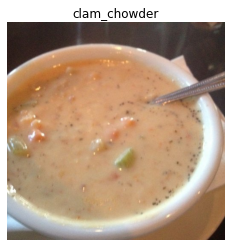

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # To check that label is matched correctly with the image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (eg. batched, normalized, etc.)

However not all data (including from Tensorflow datasets), comes like this

So in order to get it ready for a neural network, we'll often have to write preprocessing functions and map it to our data.

What we know about our data:
* In `uint8` datatype
* Comrpised of all different size tensor (different image sizes)
* Not scaled (the pixel values are between 0 and 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision tarining `float32` and `float16`)
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 and 1) also called normalized tensors generally better

With these points in mind we've got a few things we can tackle with a preprocessing function



Since we're going to be using an EfficientNEtBX pretrained model from tf.keras.applocations we dont need to rescale our data (these architectures have built in rescaling)

This means our function needs to :
* Reshape our images to same size
* Convert the dtype of our image tensors from `uint8` to `float32`

In [20]:
# MAke a function to preprocess images
def preprocess_img(image, label, img_shape=224):
    """
    Convert image datatype from 'uint8' -> 'float32' and
    reshapes to [img_shape, img_shape, colour_channel]
    """

    image = tf.image.resize(image, [img_shape, img_shape]) # Reshape traget image
    # image = image/255.  # This is not required by EfficientNetBX models
    return tf.cast(image, tf.float32), label # return a tuple of (float_32_image, label)

In [18]:
# Preprocess a single sample image and check out the outputs
preprocess_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]} ..., \nShape: {image.shape} ..., \nDatatype: {image.dtype}")
print(f"Image after preprocessing: \n {preprocess_img[:2]} ..., \nShape: {preprocess_img.shape} ..., \nDatatype: {preprocess_img.dtype}")

Image before preprocessing: 
 [[[41 32 27]
  [43 34 29]
  [43 34 29]
  ...
  [53 50 41]
  [48 48 38]
  [45 45 35]]

 [[40 31 26]
  [43 34 29]
  [45 36 31]
  ...
  [46 43 34]
  [46 46 36]
  [49 49 39]]] ..., 
Shape: (512, 512, 3) ..., 
Datatype: <dtype: 'uint8'>
Image after preprocessing: 
 [[[42.05612  33.05612  28.056124]
  [42.09694  33.09694  28.09694 ]
  [43.64796  34.21939  29.433674]
  ...
  [64.80089  55.586624 46.586624]
  [50.622417 46.69386  37.69386 ]
  [47.02044  47.02044  37.02044 ]]

 [[44.760204 35.760204 30.760204]
  [46.066326 37.066326 32.066326]
  [49.357147 39.928574 35.14286 ]
  ...
  [64.33646  56.78038  48.62224 ]
  [53.836746 49.908188 40.908188]
  [52.015156 50.224434 42.821342]]] ..., 
Shape: (224, 224, 3) ..., 
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're going to make our pipeline run really fast

For more resources on this go through :
https://www.tensorflow.org/guide/data_performance

In [21]:
# Map preprocessing function to training (and parallelize it)
train_data  = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it inot batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)

# MAp preprocsessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Creating modelling callbacks

We're going to create a couple of callbacks to help us while training our model:

* TensorBoard callback to log training results (so we can visualize them later if need be)

* ModelCheckPoint callback to save our model's progress after feature extraction

In [23]:
# Create a tensorboard callback (from helper_function.py)
from helper_functions import create_tensorboard_callback

# Create a model checkpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) #Don't print whether or not model is being saved or not

## Set up mixed precision training

https://www.tensorflow.org/guide/mixed_precision


Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance

In [25]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed_precision training

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

 ## Build feature extraction model

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape =(224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX have rescaling built-in but if your model doesnt have that you cluld yuse:
# x = preproessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # making sure the layers are in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [28]:
tf.__version__

'2.4.1'

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision ?)

In [34]:
# Check the dtype_policy attributr of layer of each layer
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name` : the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False` then weights remain frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the datatype policy a layer computers on its variables with

In [35]:
# Check the dtype policies of the layers in base model (EfficientNetB0)
for layer in model.layers[1].layers: # check the layers of layer 1 (EfficientNetB0) of the model
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the order of doing things is :

1. Build a feature extraction model (train a couple output layers with base layer frozen)
2. Fine-tune some of the frozen layers



In [36]:
histroy_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=(len(train_data)),
                                                     validation_data = test_data,
                                                     validation_steps = (0.15 * len(test_data)),
                                                     callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                                                              experiment_name="efficientnetb0_101_classes_all_data_feature_extract"),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210816-070956
Epoch 1/3
2368/2368 [==============================] - 224s 79ms/step - loss: 2.3260 - accuracy: 0.4635 - val_loss: 1.2226 - val_accuracy: 0.6744


Epoch 2/3
2368/2368 [==============================] - 172s 72ms/step - loss: 1.3121 - accuracy: 0.6627 - val_loss: 1.1262 - val_accuracy: 0.6954


Epoch 3/3
2368/2368 [==============================] - 165s 69ms/step - loss: 1.1531 - accuracy: 0.7003 - val_loss: 1.0685 - val_accuracy: 0.7064


In [37]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0887 - accuracy: 0.7055


[1.0886852741241455, 0.7055445313453674]

## Fine tuning (on own)

In [38]:
# Unfreezing some layers of the base model

base_model.trainable = True

for layer in base_model.layers[:-15]:
  layer.trainable = False

for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [39]:
# Recompiling the model with lower learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [41]:
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=15, 
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20210816-073944
Epoch 1/15
2368/2368 [==============================] - 182s 73ms/step - loss: 0.9758 - accuracy: 0.7413 - val_loss: 0.9855 - val_accuracy: 0.7315
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/15
2368/2368 [==============================] - 171s 71ms/step - loss: 0.8040 - accuracy: 0.7860 - val_loss: 0.9612 - val_accuracy: 0.7386
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/15
2368/2368 [==============================] - 173s 72ms/step - loss: 0.6922 - accuracy: 0.8177 - val_loss: 0.9739 - val_accuracy: 0.7381
Epoch 4/15
2368/2368 [==============================] - 172s 72ms/step - loss: 0.5769 - accuracy: 0.8498 - val_loss: 0.9842 - val_accuracy: 0.7397

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/15
2368/2368 [==============================] - 173s 72ms/step - loss: 0.4367 - accuracy: 0.8913 - val_loss: 1.0088 - val_accuracy: 0.7434


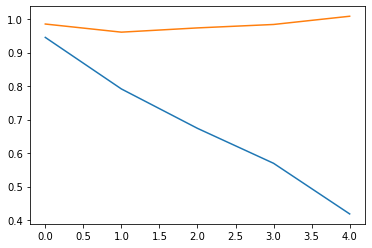

In [43]:
plt.plot(history_101_food_classes_all_data_fine_tune.history["loss"])
plt.plot(history_101_food_classes_all_data_fine_tune.history["val_loss"])

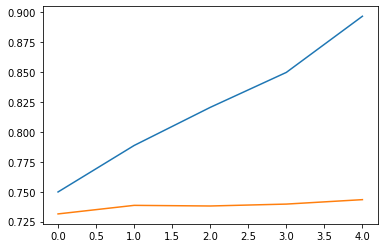

In [44]:
plt.plot(history_101_food_classes_all_data_fine_tune.history["accuracy"])
plt.plot(history_101_food_classes_all_data_fine_tune.history["val_accuracy"])

In [45]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.8, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-8)

In [46]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"])

In [47]:
history_101_food_classes_all_data_fine_tune_2 = model.fit(train_data,
                                                        epochs=15, 
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning_2"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning_2/20210816-080028
Epoch 1/15
2368/2368 [==============================] - 180s 73ms/step - loss: 0.3998 - accuracy: 0.9030 - val_loss: 1.0086 - val_accuracy: 0.7442
Epoch 2/15
2368/2368 [==============================] - 173s 72ms/step - loss: 0.3875 - accuracy: 0.9065 - val_loss: 1.0132 - val_accuracy: 0.7439
Epoch 3/15
2368/2368 [==============================] - 170s 71ms/step - loss: 0.3724 - accuracy: 0.9124 - val_loss: 1.0109 - val_accuracy: 0.7439

Epoch 00003: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
Epoch 4/15
2368/2368 [==============================] - 169s 71ms/step - loss: 0.3635 - accuracy: 0.9145 - val_loss: 1.0312 - val_accuracy: 0.7431


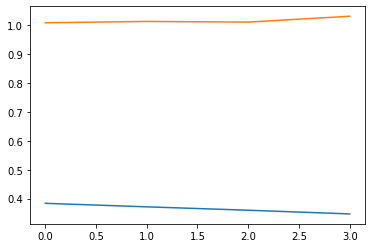

In [48]:
plt.plot(history_101_food_classes_all_data_fine_tune_2.history["loss"])
plt.plot(history_101_food_classes_all_data_fine_tune_2.history["val_loss"])

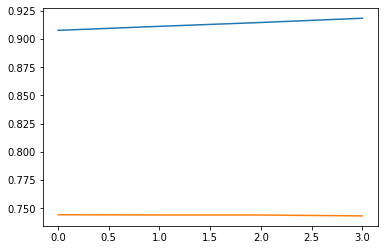

In [49]:
plt.plot(history_101_food_classes_all_data_fine_tune_2.history["accuracy"])
plt.plot(history_101_food_classes_all_data_fine_tune_2.history["val_accuracy"])

In [50]:
result_101_food_classes_all_data_fine_tune_2 = model.evaluate(test_data)
result_101_food_classes_all_data_fine_tune_2

790/790 [==============================] - 54s 68ms/step - loss: 1.0297 - accuracy: 0.7400


[1.029718041419983, 0.7399603724479675]

In [51]:
model.save("fine_tuned_101_model")

INFO:tensorflow:Assets written to: fine_tuned_101_model/assets


INFO:tensorflow:Assets written to: fine_tuned_101_model/assets
